### QQQ stock prediction using RNN, LSTM, GRU

In [115]:
from torch import nn
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [116]:
DATASET_PATH = './dataset/QQQ.csv'
assert os.path.exists(DATASET_PATH), 'Path to dataset does not exist'

In [117]:
df = pd.read_csv(DATASET_PATH)
print(df.shape)
df.head()

(1048, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,214.399994,216.160004,213.979996,216.160004,210.883881,30969400
1,2020-01-03,213.300003,215.470001,213.279999,214.179993,208.952179,27518900
2,2020-01-06,212.500000,215.589996,212.240005,215.559998,210.298523,21655300
3,2020-01-07,215.639999,216.139999,214.850006,215.529999,210.269226,22139300
4,2020-01-08,215.500000,218.139999,215.160004,217.149994,211.849686,26397300


In [118]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1.048000e+03
mean,319.103464,321.825277,316.258369,319.240229,315.282932,5.239064e+07
std,56.083078,55.877379,56.152535,56.068917,56.655009,2.277609e+07
min,170.919998,174.210007,164.929993,169.300003,165.167633,1.549880e+07
25%,281.977501,284.892502,279.737504,282.674996,278.984100,3.645432e+07
50%,318.804993,322.544998,315.994995,319.100006,316.004242,4.844750e+07
75%,364.644989,366.820000,361.794991,364.457497,360.579292,6.319948e+07
max,439.899994,446.579987,439.839996,445.609985,445.609985,1.986858e+08


<Axes: ylabel='Close'>

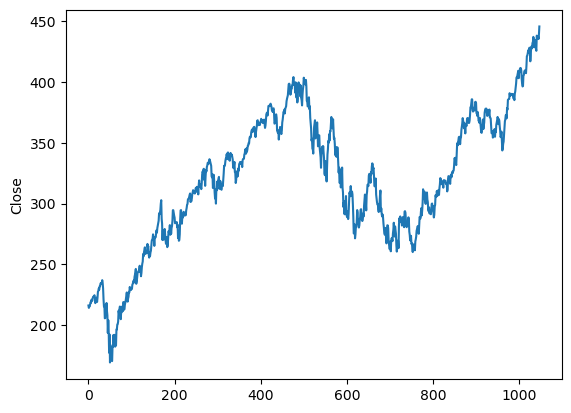

In [119]:
sns.lineplot(df, y = 'Close', x = df.index)

### Prep train and test data

In [120]:
train_df = df.drop("Date", axis = 1)
train_df = (train_df - train_df.min()) / (train_df.max() - train_df.min())
train_df.describe()


,Open,High,Low,Close,Adj Close,Volume
count,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000
mean,0.550909,0.541966,0.550465,0.542652,0.535280,0.201389
std,0.208503,0.205152,0.204258,0.202920,0.202020,0.124332
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.412884,0.406368,0.417619,0.410318,0.405846,0.114394
50%,0.549799,0.544608,0.549507,0.542145,0.537852,0.179864
75%,0.720221,0.707163,0.716107,0.706299,0.696798,0.260393
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [133]:
# def prep_series_dataset(df, timestep = 10):
#     X = []
#     y = []
#     N = len(df)
#     features = np.array(df)

#     for i in range(len(df) - timestep):
#         X.append(features[i: i + timestep])
#         y.append(features[i + timestep])
#     return np.array(X), np.array(y)

def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

#quick test
timestep = 5
# print('array = ', np.array(df[:10]['Close']))
array = np.array(df[:100]['Close'])
X,y = create_dataset(array, timestep)
print('X shape = ', X.shape)
print('y shape =', y.shape)

X shape =  torch.Size([95, 5])
y shape = torch.Size([95, 5])


In [136]:
timestep = 1

X, y = create_dataset(np.array(train_df['Close']), timestep)
X = torch.tensor(X).to(torch.float64).unsqueeze(-1)
y = torch.tensor(y).to(torch.float64)
print(X.shape, ' dtype = ', X.dtype)
print(y.shape, ' dtype = ', y.dtype) 

torch.Size([1047, 1, 1])  dtype =  torch.float64
torch.Size([1047, 1])  dtype =  torch.float64


/var/folders/_s/m9kt_szd4qq9brspl9hd44mc0000gn/T/ipykernel_25426/794898376.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X).to(torch.float64).unsqueeze(-1)
/var/folders/_s/m9kt_szd4qq9brspl9hd44mc0000gn/T/ipykernel_25426/794898376.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(torch.float64)


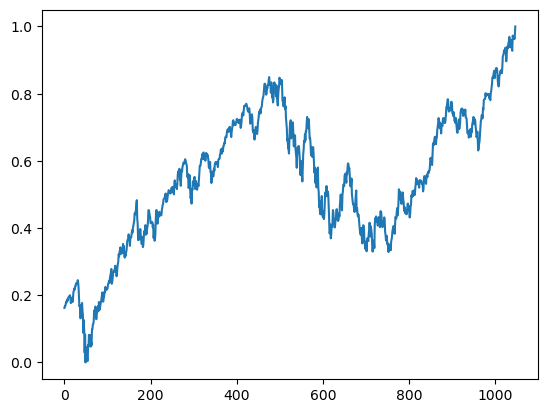

In [138]:
sns.lineplot(y = y.squeeze(-1), x = list(range(len(y))))
plt.show()

In [124]:
train_size = 0.8
x_train, x_val_test, y_train, y_val_test = train_test_split(X, y, train_size = train_size, shuffle = False)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size = 0.5, shuffle = False)

print("X train shape = ", x_train.shape)
print("y train shape = ", y_train.shape)
print("X val shape = ", x_val.shape)
print("y val shape = ", y_val.shape)
print("X test shape = ", x_test.shape)
print("y test shape = ", y_test.shape)

X train shape =  torch.Size([830, 10, 1])
y train shape =  torch.Size([830])
X val shape =  torch.Size([104, 10, 1])
y val shape =  torch.Size([104])
X test shape =  torch.Size([104, 10, 1])
y test shape =  torch.Size([104])


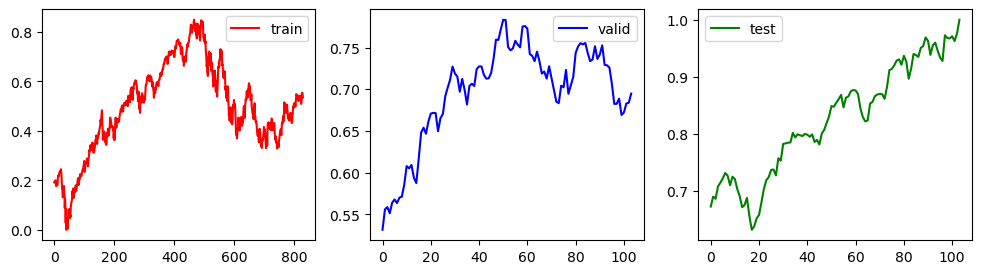

In [125]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12,3))
sns.lineplot(y = y_train, x = list(range(len(y_train))), label = 'train', ax = ax1, color = 'red')
sns.lineplot(y = y_val, x = list(range(len(y_val))), label = 'valid', ax = ax2, color = 'blue')
sns.lineplot(y = y_test, x = list(range(len(y_test))), label = 'test', ax = ax3, color = 'green')
plt.show()

In [151]:
class LSTMModel(nn.Module):
  def __init__(self, input_dim, hidden_dim = 200, num_layers=10):
    super(LSTMModel, self).__init__()
    self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dtype = torch.float64)
    self.fc = nn.LazyLinear(1, dtype = torch.float64)

  def forward(self, x):
    x, _ = self.lstm(x)
    # Get the output of the last time step
    x = x[:, -1, :]
    x = self.fc(x)
    return x

# Example usage
batch, numstep, input_size = X.shape
model = LSTMModel(input_size, 200)  # Input dim, hidden dim, output dim
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())


# # Train the model (replace with your actual training loop)
loop = tqdm(range(100))
history = []
for epoch in loop: 
  # Get predictions
  y_pred = model(X)
  loss = criterion(y_pred, y)
  
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  loop.set_description(f"loss = {loss.item()}")
  history.append(loss.item())

fig, (ax1, ax2) = plt.subplots( 1,2, figsize = (10,5))

sns.lineplot(y = history, x = list(range(len(history))), ax = ax1)
ax1.set_title('Training loss ')

y_pred = model(X)
y_pred = y_pred.squeeze(-1).detach().numpy()
print(y_pred.shape)
print(y.shape)
sns.lineplot(x = list(range(len(y_pred))), y = y_pred, label = 'Prediction', ax = ax2)
sns.lineplot(x = list(range(len(y))), y = y.squeeze(-1), label = 'Truth', ax = ax2)
ax2.set_title("Truth vs Prediction")
plt.show()


/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
loss = 0.041416946798207:  17%|█▋        | 17/100 [00:02<00:14,  5.85it/s]  